In [1]:
from typing import List, Optional
import urllib.request
from tqdm import tqdm
from pathlib import Path
import requests
import torch
import math
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import random
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader

torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)


# Setup and Exploration

In [2]:
from utils import *

In [3]:
download_quickdraw_dataset(class_names = 
    ['airplane', 'apple', 'wine bottle', 'car', 'mouth', 'pineapple', 'umbrella', 'pear', 'moustache', 'smiley face']
    + ['train', 'mosquito', 'bee', 'dragon', 'piano']
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 3992.55it/s]


In [4]:
dataset = QuickDrawDataset(root = '../data/npy')

Loading 5000 examples for each class from the Quickdraw Dataset...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 13.43it/s]


In [5]:
for c in dataset.classes:
    print(f"{c} : {dataset.classes.index(c)}")

airplane : 0
apple : 1
bee : 2
car : 3
dragon : 4
mosquito : 5
moustache : 6
mouth : 7
pear : 8
piano : 9
pineapple : 10
smiley face : 11
train : 12
umbrella : 13
wine bottle : 14


(-0.5, 27.5, 27.5, -0.5)

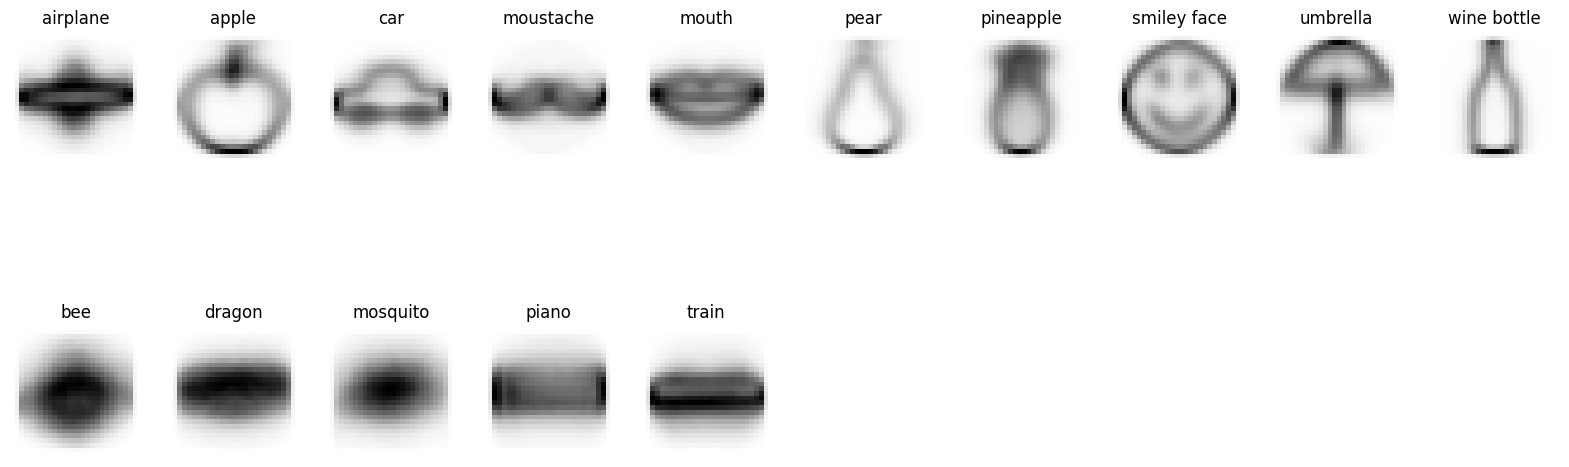

In [6]:
# create figure
fig = plt.figure(figsize=(20, 7))
  
# setting values to rows and column variables
rows = 2
columns = 10
  
    
#['train', 'mosquito', 'bee', 'dragon', 'piano']

# reading images
  
fig.add_subplot(rows, columns, 1)
dataset.draw_mean_image(0, plt)
plt.axis('off')
  
fig.add_subplot(rows, columns, 2)
dataset.draw_mean_image(1, plt)
plt.axis('off')
  
fig.add_subplot(rows, columns, 3)
dataset.draw_mean_image(3, plt)
plt.axis('off')
  
fig.add_subplot(rows, columns, 4)
dataset.draw_mean_image(6, plt)
plt.axis('off')

fig.add_subplot(rows, columns, 5)
dataset.draw_mean_image(7, plt)
plt.axis('off')
  
fig.add_subplot(rows, columns, 6)
dataset.draw_mean_image(8, plt)
plt.axis('off')
  
fig.add_subplot(rows, columns, 7)
dataset.draw_mean_image(10, plt)
plt.axis('off')
  
fig.add_subplot(rows, columns, 8)
dataset.draw_mean_image(11, plt)
plt.axis('off')

fig.add_subplot(rows, columns, 9)
dataset.draw_mean_image(13, plt)
plt.axis('off')
  
fig.add_subplot(rows, columns, 10)
dataset.draw_mean_image(14, plt)
plt.axis('off')
  
fig.add_subplot(rows, columns, 11)
dataset.draw_mean_image(2, plt)
plt.axis('off')
  
fig.add_subplot(rows, columns, 12)
dataset.draw_mean_image(4, plt)
plt.axis('off')

fig.add_subplot(rows, columns, 13)
dataset.draw_mean_image(5, plt)
plt.axis('off')

fig.add_subplot(rows, columns, 14)
dataset.draw_mean_image(9, plt)
plt.axis('off')

fig.add_subplot(rows, columns, 15)
dataset.draw_mean_image(12, plt)
plt.axis('off')


## Training

In [ ]:
train_val_split = 0.2
learning_rate = 0.001
epochs = 30
batch_size = 128
experiment_name = 'test1'


writer = SummaryWriter()

dataset = QuickDrawDataset(root = './data')
train_ds, val_ds = dataset.split(train_val_split)

train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(val_ds, batch_size=batch_size, shuffle=True)

criterion = torch.nn.CrossEntropyLoss() 
model = nn.Sequential(
    nn.Conv2d(1, 64, 3, padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(64, 128, 3, padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(128, 256, 3, padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(2304, 512),
    nn.ReLU(),
    nn.Linear(512, len(dataset.classes)),
)
#model = SimpleCNN(len(dataset.classes))


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times

    train_loss = 0.0
    valid_loss = 0.0

    for i, batch in enumerate(train_dataloader, 0):
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        logits = model(x)
        #y = y.unsqueeze(1)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        loss = criterion(logits.to(device), y.to(device))
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * batch_size
        writer.add_scalar("Loss/train_iteration", loss.item(), epoch * len(train_dataloader) + i)

    model.eval()

    for i, batch in enumerate(validation_dataloader, 0):
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        logits = model(x)

        loss = criterion(logits.to(device), y.to(device))

        valid_loss += loss.item() * batch_size

    model.train()


    writer.add_scalar("Loss/train", train_loss/len(train_dataloader.sampler), epoch)
    writer.add_scalar("Loss/test", valid_loss/len(validation_dataloader.sampler), epoch)
    writer.flush()


torch.save(model.state_dict(), './model_'+experiment_name+'.pth')
writer.close()


## Higher Resolution if needed 

In [18]:
def download_quickdraw_dataset_binary(root="./data/binary", class_names: List[str]=None):
    root = Path(root)
    root.mkdir(exist_ok=True, parents=True)
    url = 'https://storage.googleapis.com/quickdraw_dataset/full/binary/'

    print("Downloading Quickdraw Dataset...")
    for class_name in tqdm(class_names, leave=True):
        fpath = root / f"{class_name}.bin"
        if not fpath.exists():
            urllib.request.urlretrieve(f"{url}{urllib.parse.quote(class_name, safe='')}.bin", fpath)

In [19]:
download_quickdraw_dataset_binary(class_names = ['train'])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2353.71it/s]


In [20]:
import struct
from struct import unpack
import numpy as np
import cairocffi as cairo


def unpack_drawing(file_handle):
    key_id, = unpack('Q', file_handle.read(8))
    country_code, = unpack('2s', file_handle.read(2))
    recognized, = unpack('b', file_handle.read(1))
    timestamp, = unpack('I', file_handle.read(4))
    n_strokes, = unpack('H', file_handle.read(2))
    image = []
    for i in range(n_strokes):
        n_points, = unpack('H', file_handle.read(2))
        fmt = str(n_points) + 'B'
        x = unpack(fmt, file_handle.read(n_points))
        y = unpack(fmt, file_handle.read(n_points))
        image.append((x, y))

    return {
        'key_id': key_id,
        'country_code': country_code,
        'recognized': recognized,
        'timestamp': timestamp,
        'image': image
    }


def unpack_drawings(filename):
    with open(filename, 'rb') as f:
        while True:
            try:
                yield unpack_drawing(f)
            except struct.error:
                break

def vector_to_raster(vector_images, side=128, line_diameter=16, padding=16, bg_color=(0,0,0), fg_color=(1,1,1)):
    """
    padding and line_diameter are relative to the original 256x256 image.
    """
    
    original_side = 256.
    
    surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, side, side)
    ctx = cairo.Context(surface)
    ctx.set_antialias(cairo.ANTIALIAS_BEST)
    ctx.set_line_cap(cairo.LINE_CAP_ROUND)
    ctx.set_line_join(cairo.LINE_JOIN_ROUND)
    ctx.set_line_width(line_diameter)

    # scale to match the new size
    # add padding at the edges for the line_diameter
    # and add additional padding to account for antialiasing
    total_padding = padding * 2. + line_diameter
    new_scale = float(side) / float(original_side + total_padding)
    ctx.scale(new_scale, new_scale)
    ctx.translate(total_padding / 2., total_padding / 2.)

    raster_images = []
    for vector_image in vector_images:
        # clear background
        ctx.set_source_rgb(*bg_color)
        ctx.paint()
        
        bbox = np.hstack(vector_image).max(axis=1)
        offset = ((original_side, original_side) - bbox) / 2.
        offset = offset.reshape(-1,1)
        centered = [stroke + offset for stroke in vector_image]

        # draw strokes, this is the most cpu-intensive part
        ctx.set_source_rgb(*fg_color)        
        for xv, yv in centered:
            ctx.move_to(xv[0], yv[0])
            for x, y in zip(xv, yv):
                ctx.line_to(x, y)
            ctx.stroke()

        data = surface.get_data()
        raster_image = np.copy(np.asarray(data)[::4])
        raster_images.append(raster_image)
    
    return raster_images

In [21]:
image = None
for y in unpack_drawings('./data/binary/train.bin'):
    print(y.keys())
    image = y['image']
    break

dict_keys(['key_id', 'country_code', 'recognized', 'timestamp', 'image'])


In [22]:
myimg = vector_to_raster([image])

In [23]:
myimg = np.array(myimg).reshape(128,128,1)

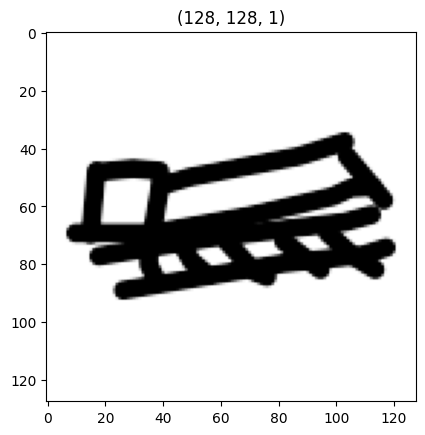

In [24]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(myimg, cmap='Greys')
plt.title(myimg.shape)
plt.show()